# Analyis for the Dark Machines Collider Unsupervised Challenge
This notebook examines the results for the [hackathon dataset](https://zenodo.org/record/3961917#.X2tooJNKhQM). The methods were trained on background only samples and then applied to a mix of background and signal. In this step of the challenge, truth information was available. This was used to determine the receiver operating characteristic (ROC) curve, the area under the ROC curve (AUC), and the signal effeficency at different fixed background rejection working points.

There are 1048 different models which were submitted. They are applied to 19 different dark matter signals across 4 channels, for a combined 34 unique channel + signature combinations.

The goal of this notebook is to determine the models which perform best across all of the physics signals for each figure of merit.

Notebook author: Bryan Ostdiek (bostdiek at g.harvard.edu)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.markers as mmark

from scipy.interpolate import interp1d

from os import walk, path

from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(f'Using numpy version {np.version.version}: known to work with 1.19.1')
print(f'Using pandas version {pd.__version__}: known to work with 1.1.1')

Using numpy version 1.19.1: known to work with 1.19.1
Using pandas version 1.1.1: known to work with 1.1.1


Some functions may not work with different versions of numpy or pandas

In [3]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

# Load Data
## Auto Encoder 
Submission by Baptiste Ravina. Details on the method can be found in section 4.1 of the paper.

In [4]:
AE = pd.read_csv('../data/AE.csv')

AEModels = list(AE['Model'].unique())
print(len(AEModels))

1


## Variational Auto Encoders
Submission by Luc Hendriks. Details on the method can be found in section 4.2 of the paper.

In [5]:
VAEs = pd.read_csv('../data/VAE.csv')

VAEModels = list(VAEs['Model'].unique())
print(len(VAEModels))

140


## Deep Set VAE
Submission by Bryan Ostdiek. Details on the method can be found in section 4.3 of the paper.

In [6]:
DeepSetVAE = pd.read_csv('../data/DeepSetVAE.csv')

DeepSetVAEModels = list(DeepSetVAE['Model'].unique())
print(len(DeepSetVAEModels))

4


## ConvVAE with and without flows.
Submission by Pratik Jawahar. Details on the methods can be found in sections 4.4 (without flows) and 4.5 (with flows).

In [7]:
ConvVAE = pd.read_csv('../data/ConvVAE_and_Flows.csv')

ConvVAEModels = list(ConvVAE['Model'].unique())
print(len(ConvVAEModels))

7


## CNN-(B)VAE
Submissions by Joe Davies. Information can be found in section 4.6 of the paper.

In [8]:
CNNVAE = pd.read_csv('../data/CNN_VAE.csv')
CNNBVAE = pd.read_csv('../data/CNN_BVAE.csv')

CNNVAEModels = list(CNNVAE['Model'].unique())
print(len(CNNVAEModels))
CNNBVAEModels = list(CNNBVAE['Model'].unique())
print(len(CNNBVAEModels))

1
1


## Density Estimation
Submission by Alessandro Morandini. Information can be found in section 4.7 of the paper.

In [9]:
KDE = pd.read_csv('../data/KDE.csv')

KDEModels = list(KDE['Model'].unique())
print(len(KDEModels))

36


## Flows
Submission by Luc Hendriks. Information can be found in section 4.8 of the paper.

In [10]:
Flows = pd.read_csv('../data/Flow.csv')

FlowsModels = list(Flows['Model'].unique())
print(len(FlowsModels))

2


## Deep SVDD
Submission by Luc Hendriks. Infromation can be found in section 4.9 of the paper.

In [11]:
DeepSVDD = pd.read_csv('../data/DeepSVDD.csv')

DeepSVDDModels = list(DeepSVDD['Model'].unique())
print(len(DeepSVDDModels))

80


## Combinations of Flows and Deep SVDD or VAE
Submission by Luc Hendriks. Information can be found in section 4.10 of the paper.

In [12]:
Combined = pd.read_csv('../data/Combined.csv')

CombinedModels = list(Combined['Model'].unique())
print(len(CombinedModels))

8


## DAGMM
Submission by Roberto Ruiz. Information can be found in section 4.11 of the paper.

In [13]:
DAGMM = pd.read_csv('../data/DAGMM.csv')

DAGMMModels = list(DAGMM['Model'].unique())
print(len(DAGMMModels))

384


## ALAD
Submission by Roberto Ruiz. Information can be found in section 4.12 of the paper.

In [14]:
ALAD = pd.read_csv('../data/ALAD.csv')

ALADModels = list(ALAD['Model'].unique())
print(len(ALADModels))

96


## Latent Space Methods
Submission by Adam Leinweber. Information can be found in section 4.13 of the paper.

In [15]:
Latent = pd.read_csv('../data/MethodsInLatentSpaceOfVAE.csv')

LatentModels = list(Latent['Model'].unique())
print(len(LatentModels))

288


## Concatenate into a single data frame

In [16]:
names = ['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
AllCombined = np.array(AE[names])
AllCombined = np.vstack([AllCombined, VAEs[names]])
AllCombined = np.vstack([AllCombined, DeepSetVAE[names]])
AllCombined = np.vstack([AllCombined, ConvVAE[names]])
AllCombined = np.vstack([AllCombined, CNNVAE[names]])
AllCombined = np.vstack([AllCombined, CNNBVAE[names]])
AllCombined = np.vstack([AllCombined, KDE[names]])
AllCombined = np.vstack([AllCombined, Flows[names]])
AllCombined = np.vstack([AllCombined, DeepSVDD[names]])  
AllCombined = np.vstack([AllCombined, Combined[names]]) 
AllCombined = np.vstack([AllCombined, DAGMM[names]])
AllCombined = np.vstack([AllCombined, ALAD[names]])
AllCombined = np.vstack([AllCombined, Latent[names]])
AllCombined = pd.DataFrame(AllCombined, columns=names)

In [17]:
AllCombined

,Signal,Model,Chan,AUC,1e-2,1e-3,1e-4
0,stop2b1000_neutralino300,SimpleAE,1,0.872,0.211,0.097,0.047
1,monojet_Zp2000.0_DM_50.0,SimpleAE,1,0.724,0.106,0.045,0.015
2,monotop_200_A,SimpleAE,1,0.714,0.13,0.077,0.037
3,glgl1400_neutralino1100,SimpleAE,1,0.79,0.15,0.083,0.043
4,stlp_st1000,SimpleAE,1,0.968,0.703,0.525,0.314
...,...,...,...,...,...,...,...
35547,sqsq1_sq1400_neut800,LS_Average_4_0.1_10000,3,0.795075,0.0478249,0.00681342,0.00222746
35548,sqsq1_sq1400_neut800,LS_Average_4_1.0_1000,3,0.805776,0.16326,0.019261,0.00393082
35549,sqsq1_sq1400_neut800,LS_Average_4_1.0_10000,3,0.765942,0.137317,0.0259434,0.00366876
35550,sqsq1_sq1400_neut800,LS_Average_4_1e-05_1000,3,0.875899,0.200996,0.0476939,0.0086478


Check to make sure all models have results for all of the signals.

In [18]:
incomplete_models = []
for Chan in ['1', '2a', '2b', '3']:
    for mod in list(AllCombined['Model'].unique()):
        if mod not in list(AllCombined[AllCombined['Chan'] == Chan]['Model']):
            print(f'Missing Chan {Chan} for {mod}')
            incomplete_models.append(mod)

print(f'....Dropping {len(incomplete_models)} incomplete models')
AllCombined = AllCombined[~AllCombined['Model'].isin(incomplete_models)]

print(f'\nResults are computed for {AllCombined.Model.unique().shape[0]} models')

Missing Chan 3 for DeepSVDD_Reduced_d377
Missing Chan 3 for DeepSVDD_C0_d377
Missing Chan 3 for DeepSVDD_C1_d377
Missing Chan 3 for DeepSVDD_C2_d377
Missing Chan 3 for DeepSVDD_C3_d377
Missing Chan 3 for DeepSVDD_C4_d377
Missing Chan 3 for DeepSVDD_C10_d377
Missing Chan 3 for DeepSVDD_C25_d377
....Dropping 8 incomplete models

Results are computed for 1040 models


# Analyze By Metric
The models will be grouped by the method of determining which does best, i.e. having the highest minimum or the highest average for each figure of merit $\left(\rm{AUC}, \epsilon_S(\epsilon_B = 10^{-2}), \cdots\right)$. The models which do best by this method for each metric will be shown on the same plot.

In [19]:
def AnalyzeByMethod(CombinedDataFrame, Chan, Method, MetricNumberDict, Plot):
    """
    Inputs:
        CombineedDataFrame: Pandas dataframe with columns ['Model', 'Signal', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
        Chan: String with which signal chanel is being analyzed. Must be one of ['1', '2a', '2b', '3', 'All']
        Method: String indicating the metric to use, must be one of ['top1', 'top5', 'AverageRank', 'MeanScore', 'MedianScore', 'MinScore']
        MetricNumberDict: The number of models to include for each sorting. Will usually include 5, 
            but some of the rankings need different numbers.
            example: MetricNumberDict = {'AUC': 5, 
                                         '1e-2': 5,
                                         '1e-3': 5,
                                         '1e-4': 5}
        Plot: Boolean if to make bar plots or not
        
    """
    for col in ['Model', 'Signal', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']:
        if col not in CombinedDataFrame.columns:
            print(f'CombinedDataFrame is missing column {col}')
            return 0
    if Chan not in ['1', '2a', '2b', '3', 'All']:
        print(f'Invalid "Chan" selection: {Chan}')
        return 0
    if Method not in ['top1', 'top5', 'AverageRank', 'MeanScore', 'MedianScore', 'MinScore']:
        print(f'Invalid "Method" selection: {Method}')
        return 0
    
    if Chan != 'All':
        AnalyzeFrame = CombinedDataFrame[CombinedDataFrame['Chan'] == Chan]
    else:
        AnalyzeFrame = CombinedDataFrame
    
    # This helper variable combines the channel and signal since some signals appear in multiple channels
    chansig = AnalyzeFrame['Chan'] + '/' + AnalyzeFrame['Signal']
    chansig = np.unique(chansig)
    sigs = AnalyzeFrame.Signal.unique()
    mods = AnalyzeFrame.Model.unique()
    SortedScores = pd.DataFrame()
    SortedScores['Model'] = mods
    
    SortedScores = {}
    BestC = []
    TopDict = {}
    for Metric in ['AUC', '1e-2', '1e-3', '1e-4']:
        SortedScores[Metric] = pd.DataFrame()
        SortedScores[Metric]['Model'] = mods
        
        # Go through each of the signals to find the ranking of the models for AUC

        for sig in chansig:
            chan, sig = sig.split('/')
            cs = AnalyzeFrame[(AnalyzeFrame['Signal'] == sig) & (AnalyzeFrame['Chan']==chan)]
            scorelist = cs[Metric]
            score_ranking = np.zeros_like(scorelist)
            for i, score in enumerate(np.argsort(-scorelist)):  # argsort gives the ordering to sort them, we want the orthogonal information
                score_ranking[score] = i
            SortedScores[Metric][sig] = score_ranking
        SortedScores[Metric]['AverageRank'] = SortedScores[Metric][[col for col in SortedScores[Metric].columns if 'Model' not in col]].mean(axis=1)
        SortedScores[Metric]['top1'] = (SortedScores[Metric][[col for col in SortedScores[Metric].columns if (('AverageRank' not in col)
                                                                                      and ('Model' not in col)
                                                                                     )]] < 1).sum(axis=1)
        SortedScores[Metric]['top5'] = (SortedScores[Metric][[col for col in SortedScores[Metric].columns if (('AverageRank' not in col) and 
                                                                                      ('top1' not in col) and
                                                                                      ('Model' not in col)
                                                                                     )]] < 5).sum(axis=1)

        meanscore = []
        medianscore = []
        minscore = []
        for m in mods:
            tmpdf = AnalyzeFrame[AnalyzeFrame['Model'] == m]
            tmpscores = tmpdf[Metric]
            meanscore.append(tmpscores.mean())
            medianscore.append(tmpscores.median())
            minscore.append(tmpscores.min())
        SortedScores[Metric]['MeanScore'] = meanscore
        SortedScores[Metric]['MedianScore'] = medianscore
        SortedScores[Metric]['MinScore'] = minscore
    
        num = MetricNumberDict[Metric]
        if num == 0: continue
        TopDict[Metric] = SortedScores[Metric].sort_values(by=Method,ascending=True if Method =='AverageRank' else False)[['Model']][:num].to_numpy().reshape(num)
        BestC += list(TopDict[Metric])
        print('*'*40)
        print(f'Models from chan={Chan} ranked by metric={Metric} sorted by {Method}')
        print(SortedScores[Metric].sort_values(by=Method,ascending=True if Method =='AverageRank' else False)[['Model', Method]][:num])
        print('*'*40)
        print()
        
    if Plot:
        nameddict = {'top1': 'Top score on a signal',
                     'top5': 'Top 5 score on a signal',
                     'AverageRank': 'Average Rank',
                     'MeanScore': 'Mean Score',
                     'MedianScore': 'Median Score',
                     'MinScore': 'Minimum Score'
                    }
        name = nameddict[Method]
        BestC = np.array(BestC).flatten()
        BestCU = np.unique(BestC)
        
        plt.figure(figsize=(8, 5))

        for colnum, col in enumerate(['AUC', '1e-2', '1e-3', '1e-4']):
            colors = ['grey' for m in BestCU]
            
            if col in TopDict:
                for bestnum, m in enumerate(TopDict[col]):
                    for mnum, mtop in enumerate(BestCU):
                        if m == mtop:
                            colors[mnum] = f'C{bestnum}'
            ax = plt.subplot(1, 4, colnum + 1)
            yvs=[]
            names = []
            data_all = []
            for i,m in enumerate(BestCU):
                tmp_data = []
                tmpdf = AnalyzeFrame[AnalyzeFrame['Model']==m].copy()
                for s in chansig:
                    chan, s = s.split('/')
                    tmpauc = tmpdf[(tmpdf['Signal'] == s) & (tmpdf['Chan']==chan)][col]
                    tmp_data.append(tmpauc)
                data_all.append(np.array(tmp_data).reshape(len(chansig)))
                yvs.append(i)
                names.append(m)
            databp = np.array(data_all).reshape(len(BestCU), len(chansig))
            databp[databp == 0] = 1e-10
            bbox1 = plt.boxplot(databp.T,
                        vert=False,
                        manage_ticks=False,
                        patch_artist=True,
                        medianprops={'color':'k'},
                        positions=yvs
                       )

            if colnum == 0:
                plt.yticks(yvs, [n.replace('_', r'$\_$') for n in names])
                plt.xlim(0, 1)
            else:
                plt.yticks(yvs, [])
                plt.xscale('log')
                plt.xlim(1e-4, 1)
                plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])


            for patch, color, flier in zip(bbox1['boxes'], colors, bbox1['fliers']):
                patch.set_facecolor(color)
                flier.set_markerfacecolor(color)
                flier.set_markerfacecolor(color)
                flier.set_markeredgecolor(color)
            plt.minorticks_on()
            plt.grid()
            
            if col == 'AUC':
                plt.xlabel(col)
            elif col == '1e-2':
                plt.xlabel(r'$\epsilon_S(\epsilon_B=10^{-2})$')
            elif col == '1e-3':
                plt.xlabel(r'$\epsilon_S(\epsilon_B=10^{-3})$')
            elif col == '1e-4':
                plt.xlabel(r'$\epsilon_S(\epsilon_B=10^{-4})$')
            
        legend_elements = [Patch(facecolor='C0', edgecolor='k',
                         label='Best'),
                   Patch(facecolor='C1', edgecolor='k',
                         label='2nd'),
                   Patch(facecolor='C2', edgecolor='k',
                         label='3rd'),
                   Patch(facecolor='C3', edgecolor='k',
                         label='4th'),
                   Patch(facecolor='C4', edgecolor='k',
                         label='5th')
                  ]
        plt.legend(handles=legend_elements, 
                   loc=(1.05,0.3), 
                   labelspacing=1,
                   facecolor='white',
                   framealpha=1,
                   frameon=True)

        if Chan == 'All':
            plt.suptitle(r'Best models on all channels of $hackathon$ $data$' + f' combined based on {name.lower()}')
        else:
            plt.suptitle(rf'Best models on channel {Chan} of $hackathon$ $data$ based on {name.lower()}')
        plt.savefig(f'../figures/TopChan{Chan}_{name.replace(" ", "_")}_boxplot.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

## All Channels

### Top Score on a figure of merit

****************************************
Models from chan=All ranked by metric=AUC sorted by top1
                              Model  top1
190       Flow-Efficient_Likelihood     7
191  Flow-Efficient-No-E_Likelihood     4
147              VAE_HouseholderSNF     3
267      Combined-AVG-DeepSVDD-Flow     3
265       Combined-OR-DeepSVDD-Flow     2
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by top1
                              Model  top1
266     Combined-PROD-DeepSVDD-Flow     7
191  Flow-Efficient-No-E_Likelihood     6
267      Combined-AVG-DeepSVDD-Flow     3
190       Flow-Efficient_Likelihood     2
227                DeepSVDD_C2_d233     1
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by top1
                              Model  top1
191  Flow-Efficient-No-E_Likelihood     8
267      Combined-AVG-DeepSVDD-F

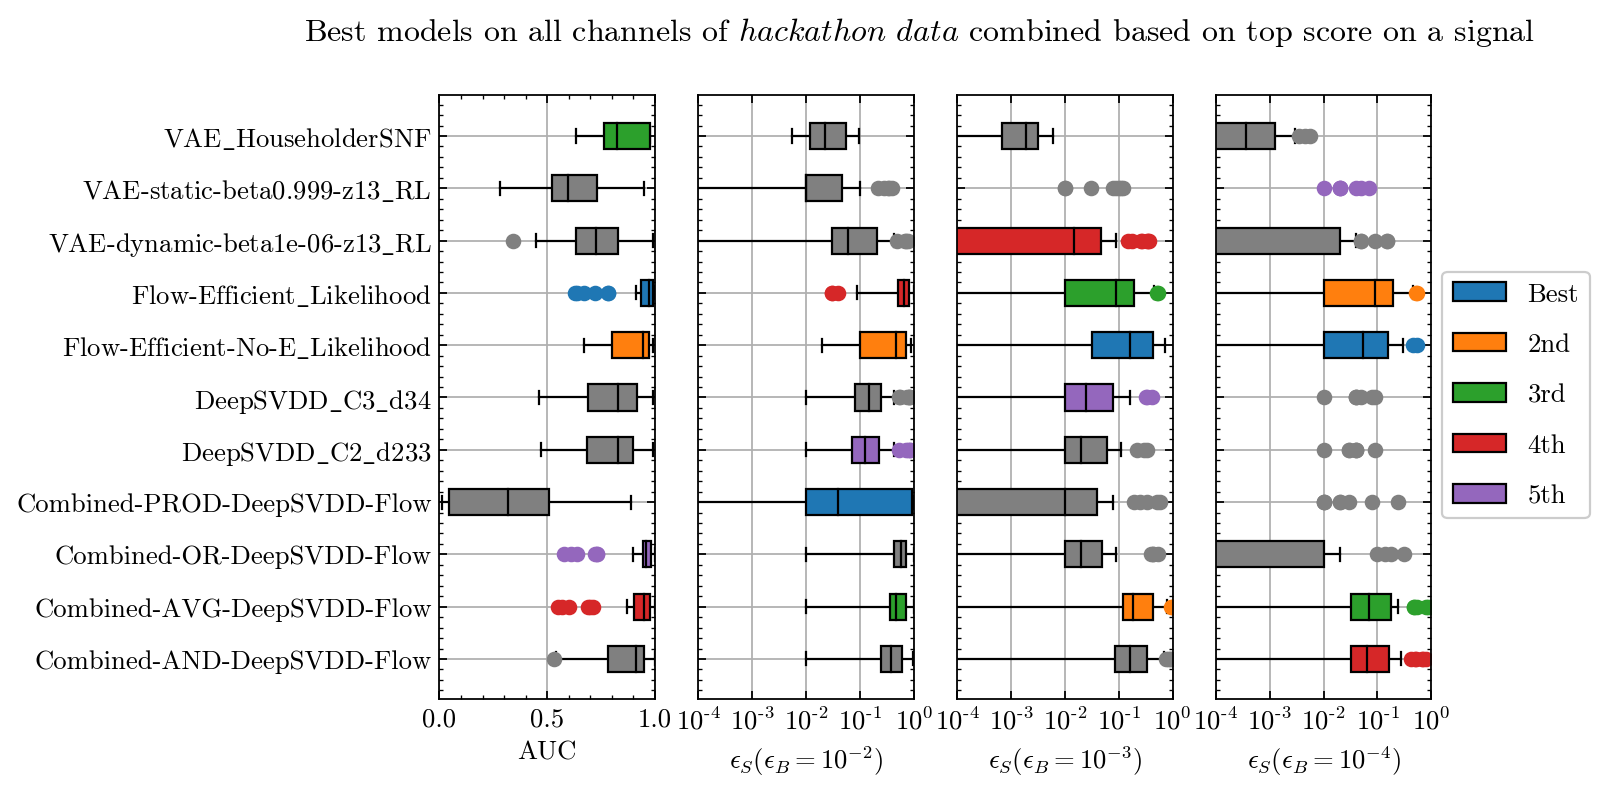

In [20]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='top1', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Most top 5 scores on a figure of merit

****************************************
Models from chan=All ranked by metric=AUC sorted by top5
                              Model  top5
190       Flow-Efficient_Likelihood    17
265       Combined-OR-DeepSVDD-Flow    14
269  Combined-OR-VAE_beta1_z21-Flow    12
267      Combined-AVG-DeepSVDD-Flow    12
191  Flow-Efficient-No-E_Likelihood    10
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by top5
                              Model  top5
190       Flow-Efficient_Likelihood    16
265       Combined-OR-DeepSVDD-Flow    13
269  Combined-OR-VAE_beta1_z21-Flow    13
267      Combined-AVG-DeepSVDD-Flow    12
191  Flow-Efficient-No-E_Likelihood     8
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by top5
                                Model  top5
267        Combined-AVG-DeepSVDD-Flow    14
264        Combined-AND-Deep

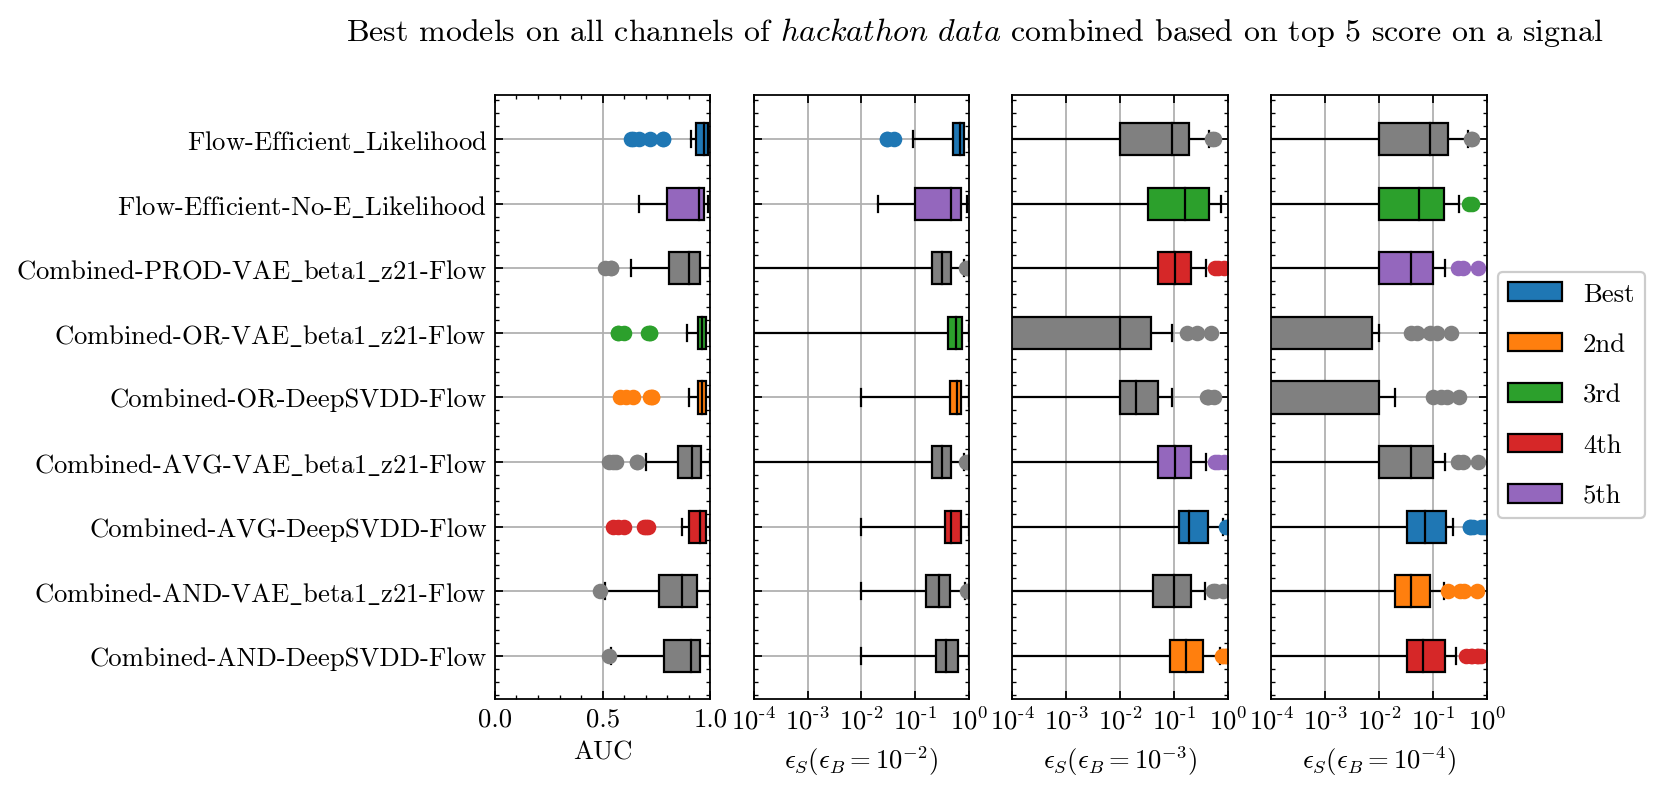

In [21]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='top5', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top Average Ranking for a figure of merit

****************************************
Models from chan=All ranked by metric=AUC sorted by AverageRank
                               Model  AverageRank
190        Flow-Efficient_Likelihood     3.842105
267       Combined-AVG-DeepSVDD-Flow     4.000000
265        Combined-OR-DeepSVDD-Flow     6.631579
269   Combined-OR-VAE_beta1_z21-Flow     9.157895
271  Combined-AVG-VAE_beta1_z21-Flow    12.210526
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by AverageRank
                              Model  AverageRank
190       Flow-Efficient_Likelihood     8.736842
265       Combined-OR-DeepSVDD-Flow    13.842105
267      Combined-AVG-DeepSVDD-Flow    18.947368
269  Combined-OR-VAE_beta1_z21-Flow    27.736842
264      Combined-AND-DeepSVDD-Flow    52.947368
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by AverageRank
     

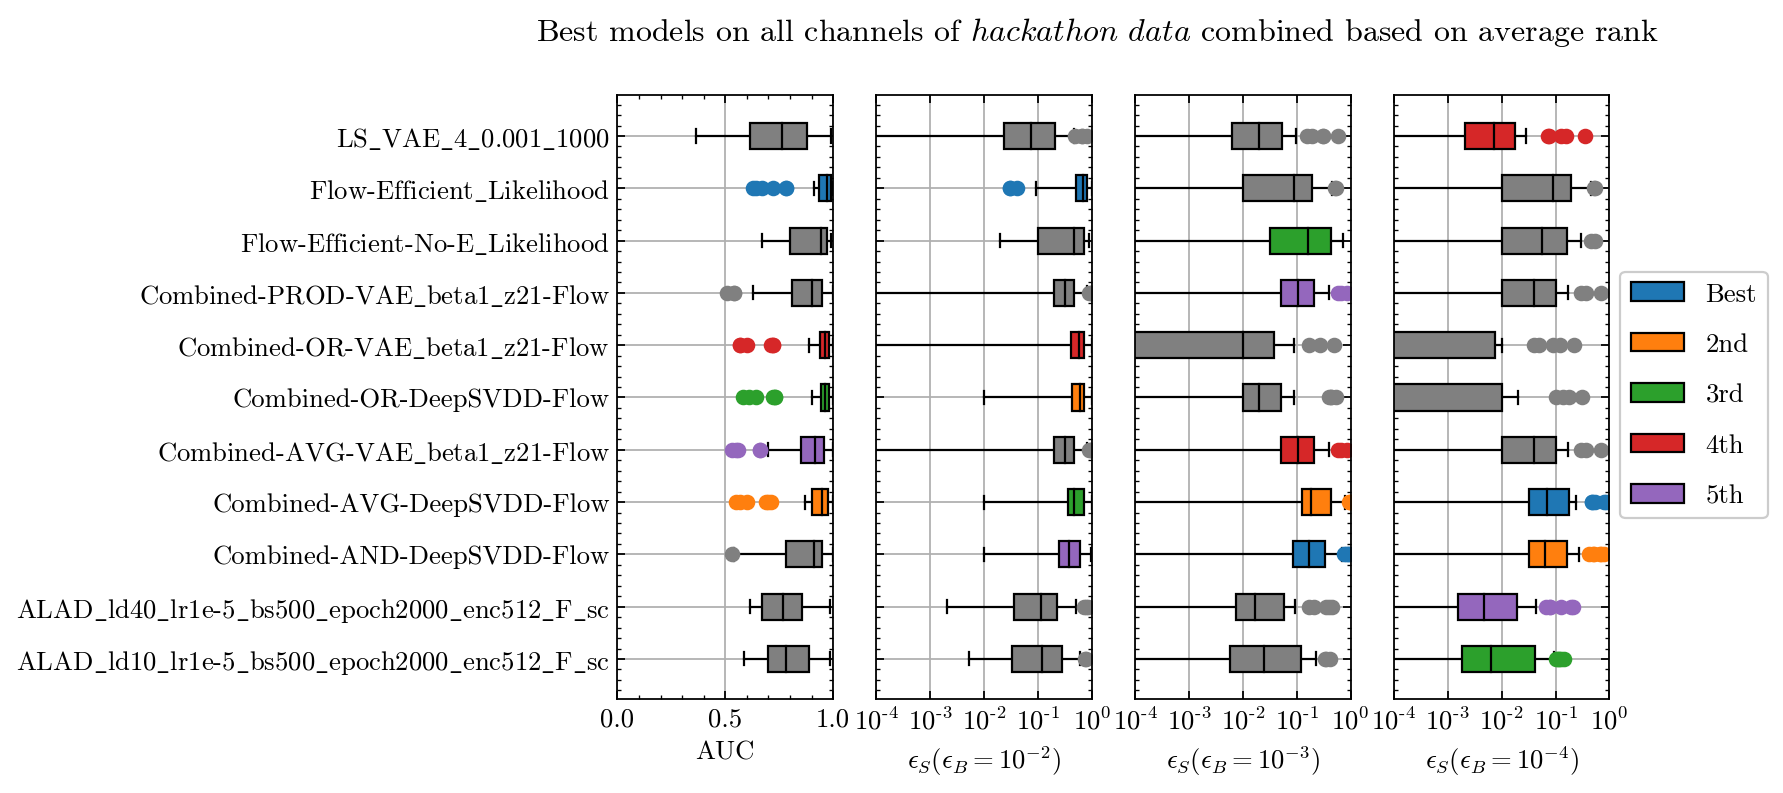

In [22]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='AverageRank', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top Mean score for a figure of merit

****************************************
Models from chan=All ranked by metric=AUC sorted by MeanScore
                              Model  MeanScore
190       Flow-Efficient_Likelihood   0.922941
265       Combined-OR-DeepSVDD-Flow   0.917059
269  Combined-OR-VAE_beta1_z21-Flow   0.909118
267      Combined-AVG-DeepSVDD-Flow   0.898529
191  Flow-Efficient-No-E_Likelihood   0.884118
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by MeanScore
                              Model  MeanScore
190       Flow-Efficient_Likelihood   0.594706
265       Combined-OR-DeepSVDD-Flow   0.545882
269  Combined-OR-VAE_beta1_z21-Flow   0.531765
267      Combined-AVG-DeepSVDD-Flow   0.495294
191  Flow-Efficient-No-E_Likelihood   0.438529
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by MeanScore
                                Model  Me

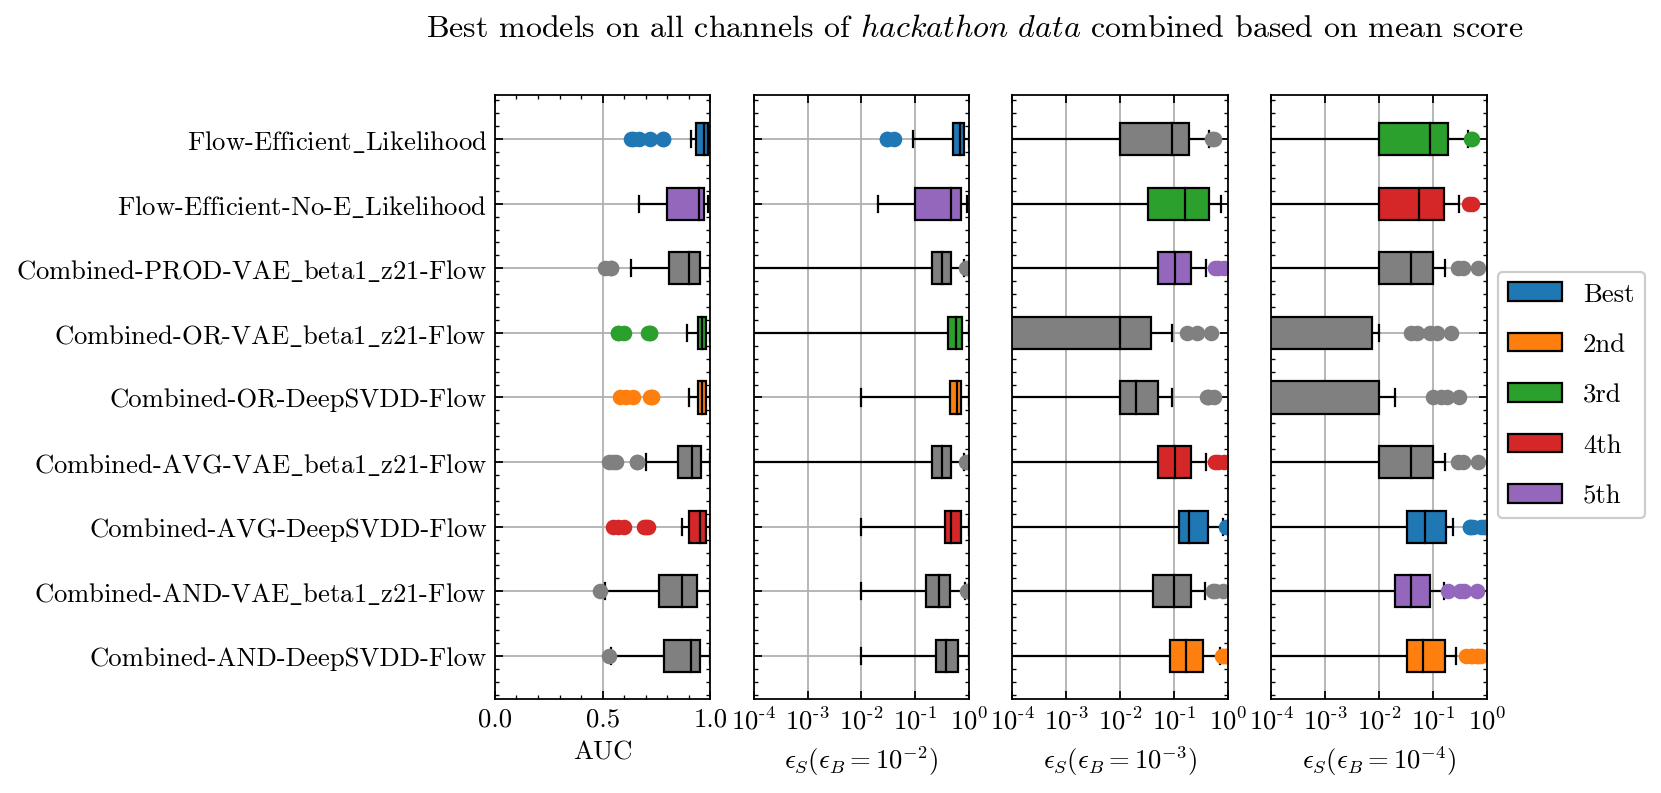

In [23]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='MeanScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top median score for a figure of merit

****************************************
Models from chan=All ranked by metric=AUC sorted by MedianScore
                              Model  MedianScore
190       Flow-Efficient_Likelihood        0.970
269  Combined-OR-VAE_beta1_z21-Flow        0.960
265       Combined-OR-DeepSVDD-Flow        0.960
267      Combined-AVG-DeepSVDD-Flow        0.950
191  Flow-Efficient-No-E_Likelihood        0.945
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by MedianScore
                              Model  MedianScore
190       Flow-Efficient_Likelihood        0.670
265       Combined-OR-DeepSVDD-Flow        0.590
269  Combined-OR-VAE_beta1_z21-Flow        0.575
191  Flow-Efficient-No-E_Likelihood        0.465
267      Combined-AVG-DeepSVDD-Flow        0.460
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by MedianScore
           

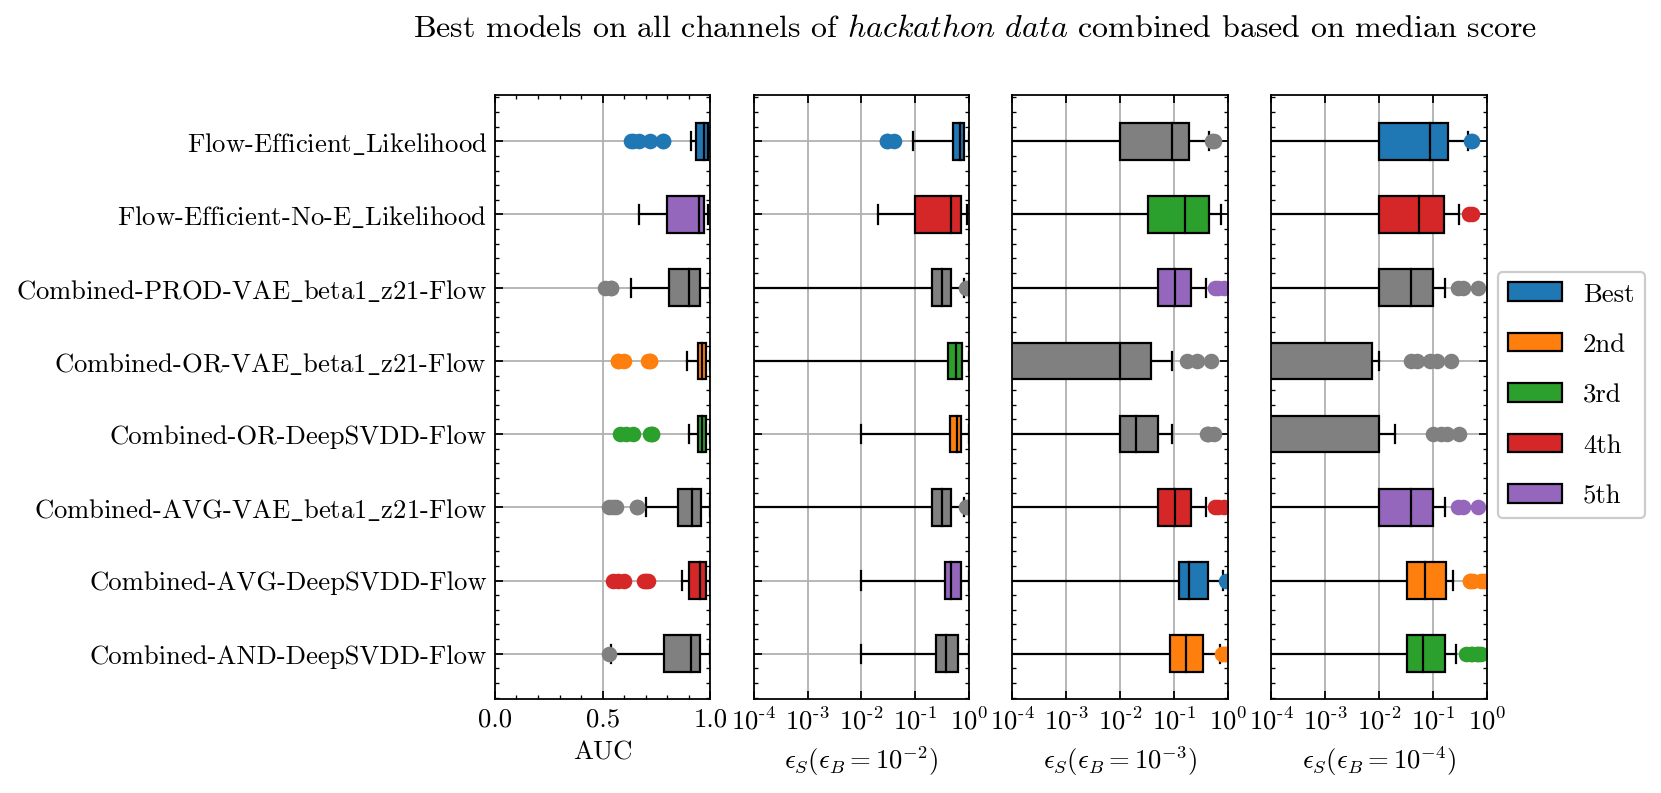

In [24]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='MedianScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top minimum score on a figure of merit

Note that we have decreased the number of models for the last two figures of merit, because only 1 (or none) are non zero.

****************************************
Models from chan=All ranked by metric=AUC sorted by MinScore
                              Model  MinScore
191  Flow-Efficient-No-E_Likelihood  0.670000
148               VAE_OrthogonalSNF  0.666274
150                         VAE_IAF  0.655265
147              VAE_HouseholderSNF  0.634438
190       Flow-Efficient_Likelihood  0.630000
****************************************

****************************************
Models from chan=All ranked by metric=1e-2 sorted by MinScore
                              Model  MinScore
190       Flow-Efficient_Likelihood  0.030000
191  Flow-Efficient-No-E_Likelihood  0.020000
0                          SimpleAE  0.013274
219                  DeepSVDD_C2_d5  0.010000
213                 DeepSVDD_C1_d21  0.010000
****************************************

****************************************
Models from chan=All ranked by metric=1e-3 sorted by MinScore
                                            Model  MinSc

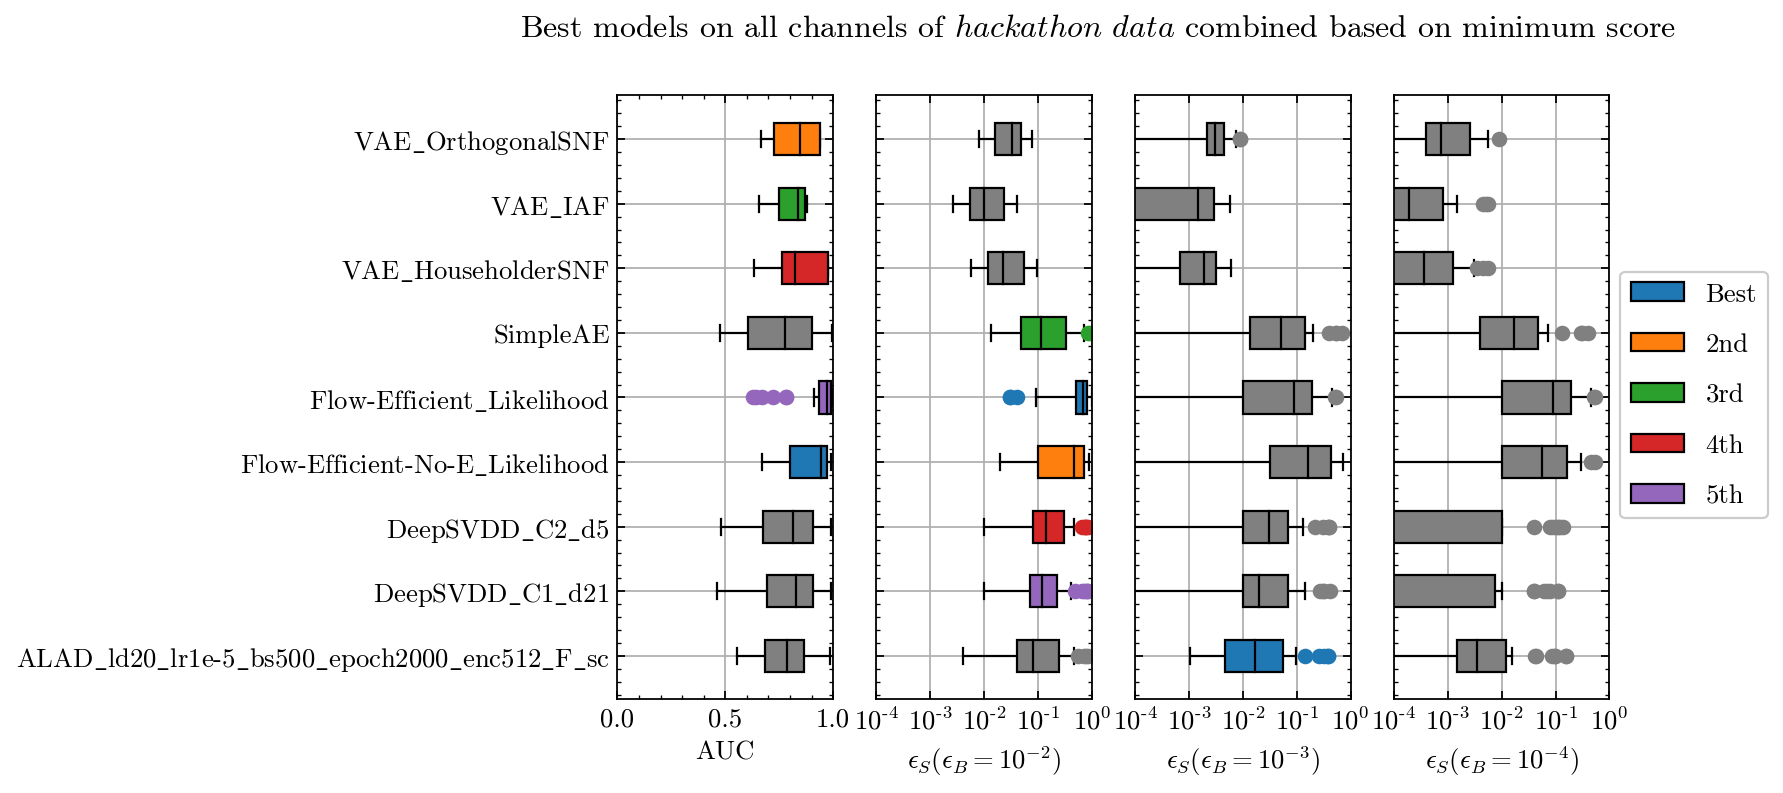

In [25]:
AnalyzeByMethod(AllCombined, 
                Chan='All', 
                Method='MinScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 1,
                                  '1e-4': 0}, 
                Plot=True
               )

## Scan through individual channels
These plots are not in the paper, but could be useful for comparison. The ones above combine across all channels (signal regions). Here, we look at each individually.

### Chan1
#### Top score a figure of merit

****************************************
Models from chan=1 ranked by metric=AUC sorted by top1
                              Model  top1
267      Combined-AVG-DeepSVDD-Flow     3
265       Combined-OR-DeepSVDD-Flow     2
190       Flow-Efficient_Likelihood     2
191  Flow-Efficient-No-E_Likelihood     1
0                          SimpleAE     0
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by top1
                                            Model  top1
267                    Combined-AVG-DeepSVDD-Flow     5
190                     Flow-Efficient_Likelihood     2
191                Flow-Efficient-No-E_Likelihood     1
0                                        SimpleAE     0
693  ALAD_ld40_lr1e-5_bs5000_epoch2000_enc512_L_2     0
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by top1
                                      

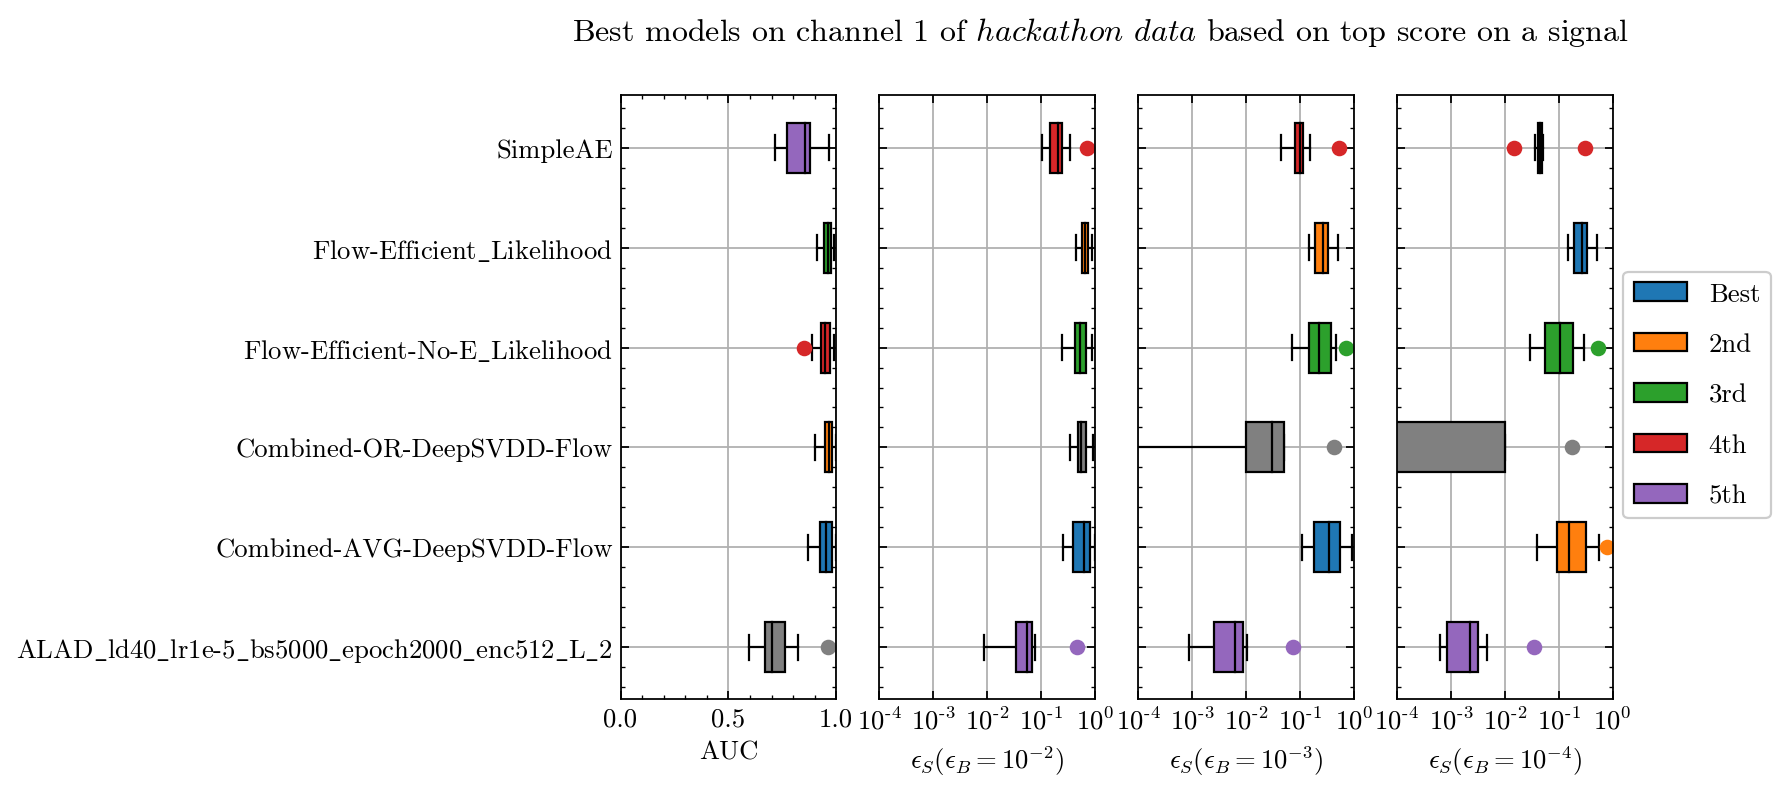

In [26]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='top1', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Most top 5 scores on a figure of merit

****************************************
Models from chan=1 ranked by metric=AUC sorted by top5
                              Model  top5
265       Combined-OR-DeepSVDD-Flow     8
267      Combined-AVG-DeepSVDD-Flow     8
269  Combined-OR-VAE_beta1_z21-Flow     8
190       Flow-Efficient_Likelihood     7
191  Flow-Efficient-No-E_Likelihood     6
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by top5
                              Model  top5
265       Combined-OR-DeepSVDD-Flow     8
267      Combined-AVG-DeepSVDD-Flow     8
190       Flow-Efficient_Likelihood     8
191  Flow-Efficient-No-E_Likelihood     6
269  Combined-OR-VAE_beta1_z21-Flow     5
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by top5
                              Model  top5
264      Combined-AND-DeepSVDD-Flow     8
267      Combined-AVG-DeepSVDD-Flow   

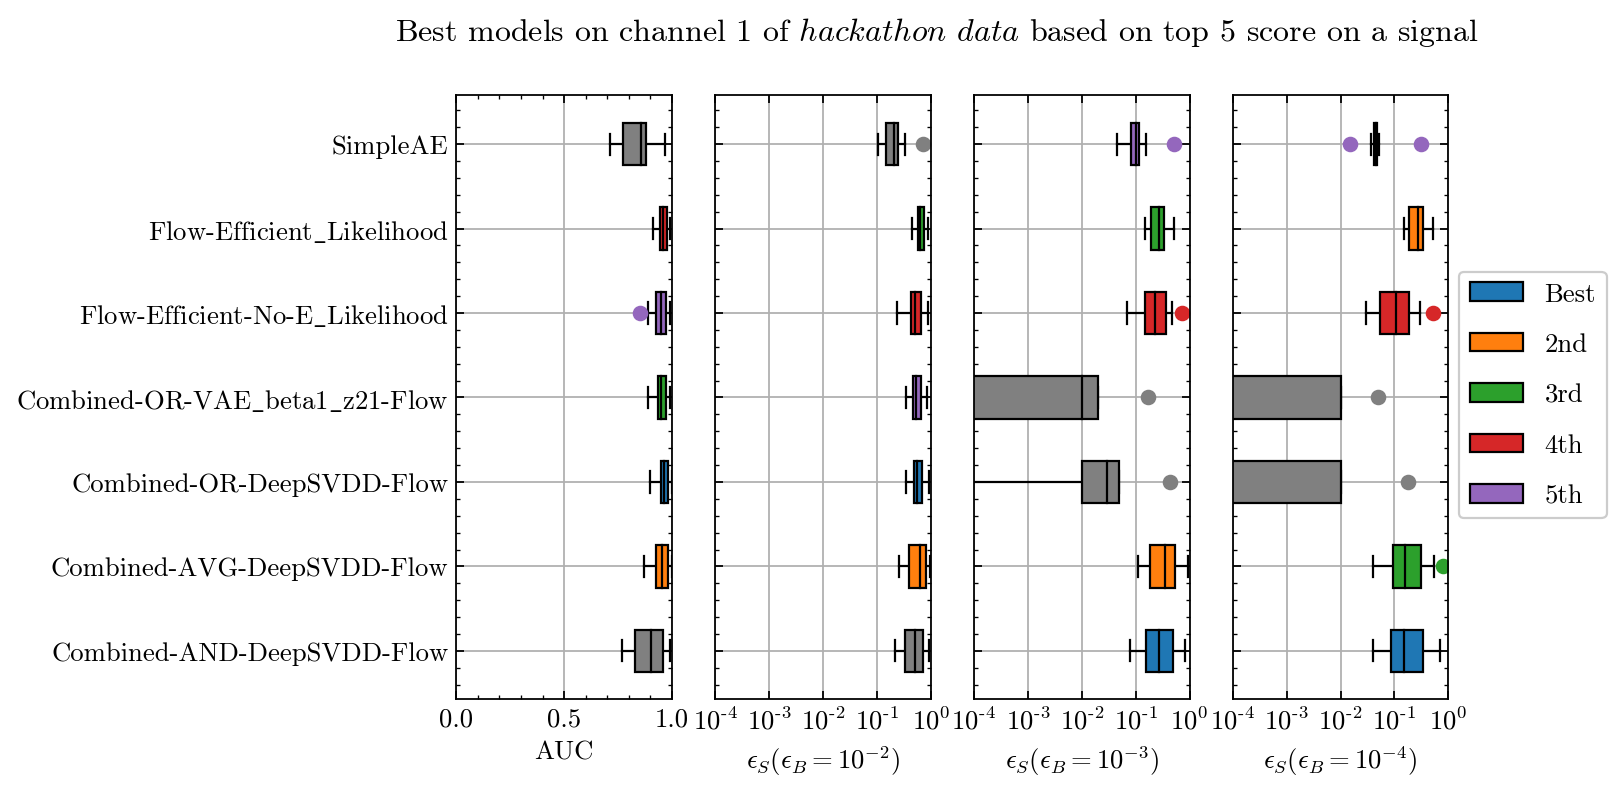

In [27]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='top5', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top average rank

****************************************
Models from chan=1 ranked by metric=AUC sorted by AverageRank
                              Model  AverageRank
265       Combined-OR-DeepSVDD-Flow        1.000
267      Combined-AVG-DeepSVDD-Flow        1.750
190       Flow-Efficient_Likelihood        2.250
269  Combined-OR-VAE_beta1_z21-Flow        2.875
264      Combined-AND-DeepSVDD-Flow        6.125
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by AverageRank
                              Model  AverageRank
267      Combined-AVG-DeepSVDD-Flow        1.250
190       Flow-Efficient_Likelihood        1.375
265       Combined-OR-DeepSVDD-Flow        2.500
264      Combined-AND-DeepSVDD-Flow        3.250
269  Combined-OR-VAE_beta1_z21-Flow        3.875
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by AverageRank
                 

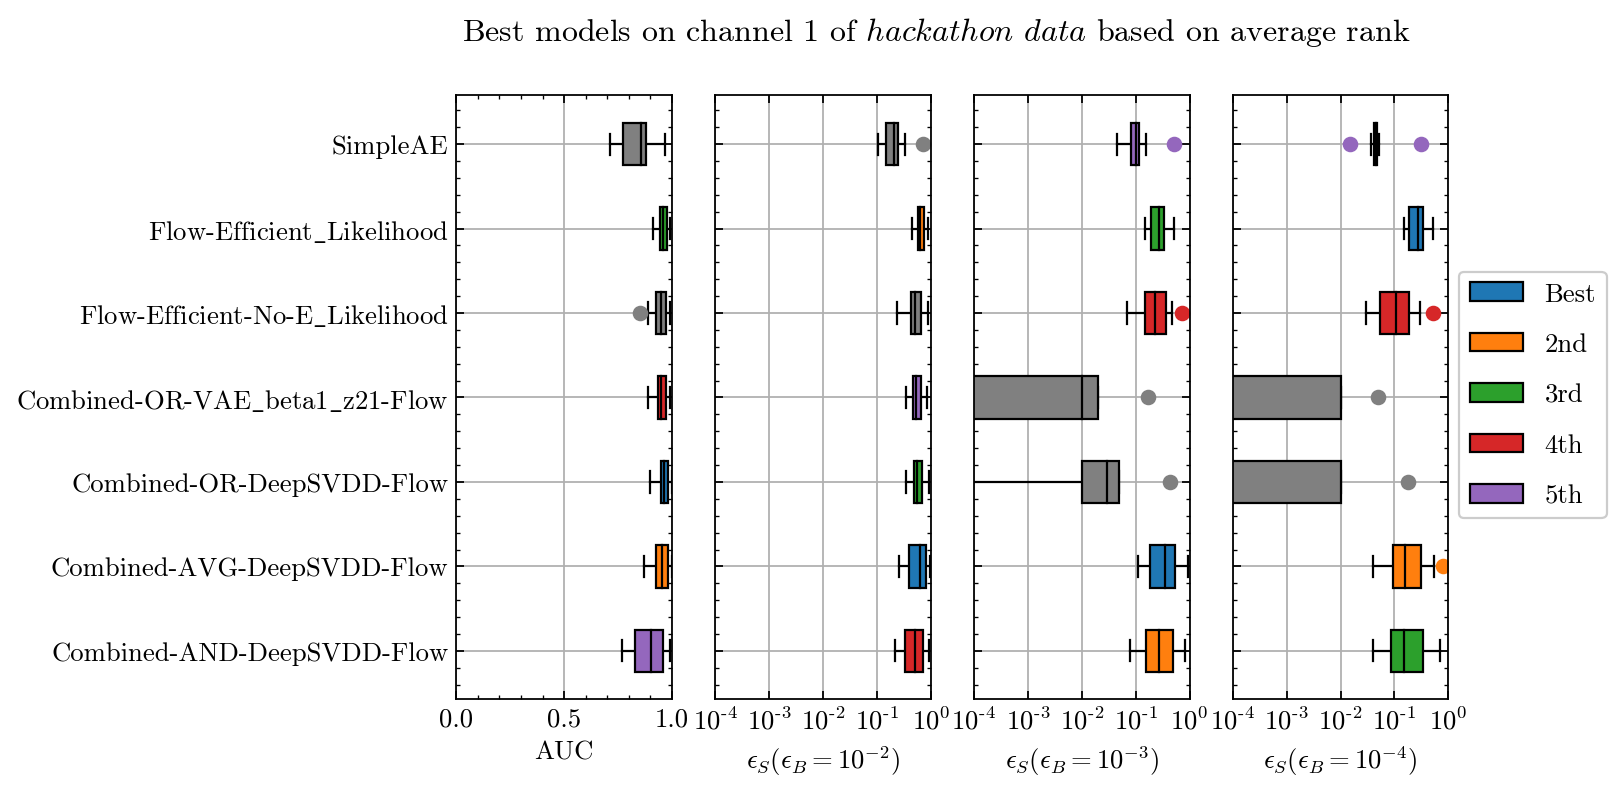

In [28]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='AverageRank', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Mean score

****************************************
Models from chan=1 ranked by metric=AUC sorted by MeanScore
                              Model  MeanScore
265       Combined-OR-DeepSVDD-Flow    0.96125
190       Flow-Efficient_Likelihood    0.95750
269  Combined-OR-VAE_beta1_z21-Flow    0.94875
267      Combined-AVG-DeepSVDD-Flow    0.94875
191  Flow-Efficient-No-E_Likelihood    0.93875
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by MeanScore
                              Model  MeanScore
190       Flow-Efficient_Likelihood    0.65750
267      Combined-AVG-DeepSVDD-Flow    0.61625
265       Combined-OR-DeepSVDD-Flow    0.59375
269  Combined-OR-VAE_beta1_z21-Flow    0.56875
264      Combined-AND-DeepSVDD-Flow    0.54250
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by MeanScore
                              Model  MeanScore


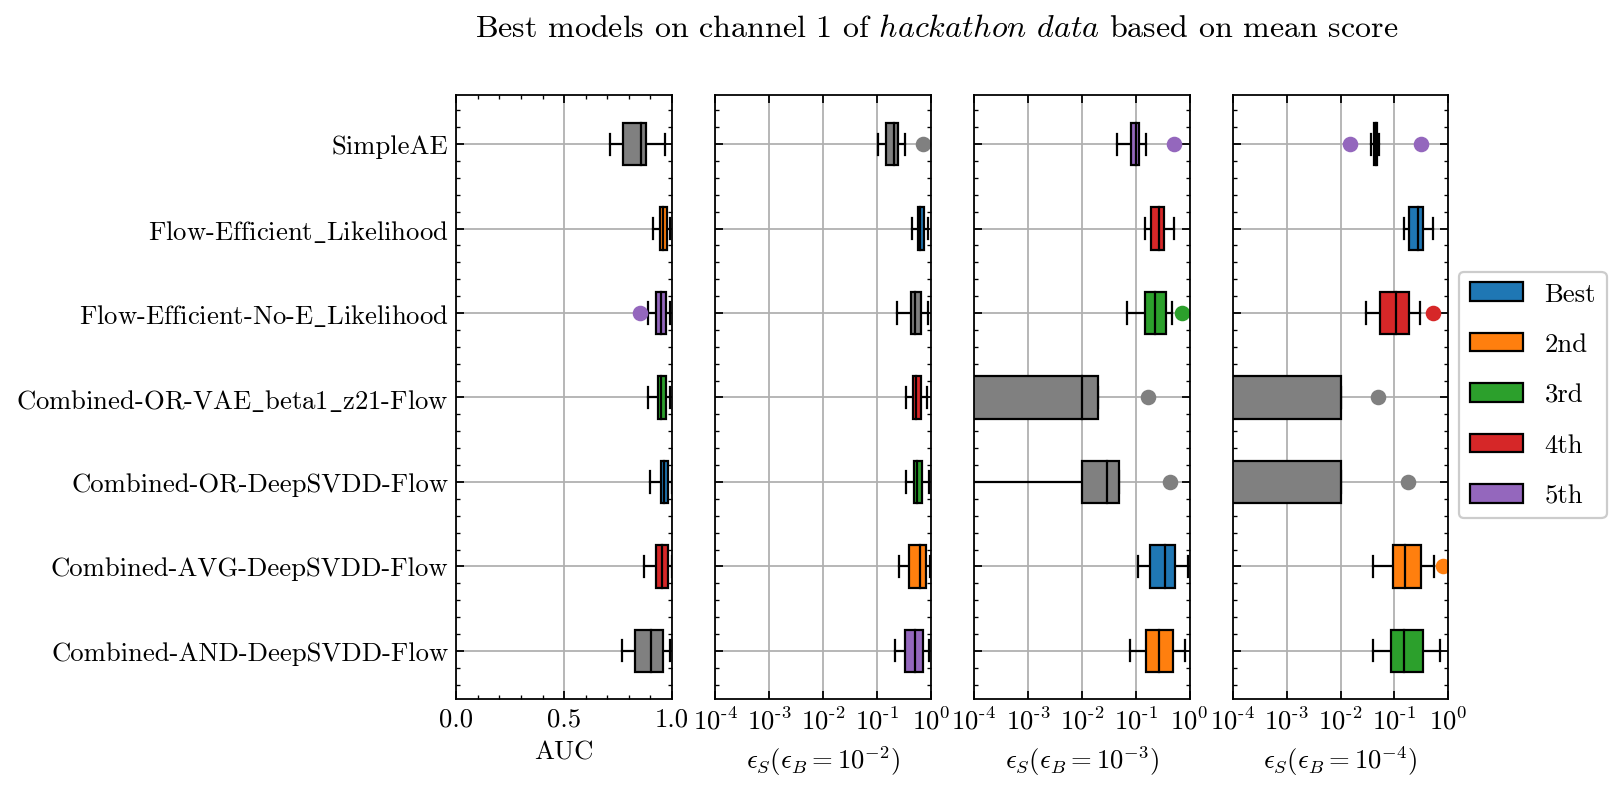

In [29]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='MeanScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Median Score

****************************************
Models from chan=1 ranked by metric=AUC sorted by MedianScore
                              Model  MedianScore
265       Combined-OR-DeepSVDD-Flow        0.965
190       Flow-Efficient_Likelihood        0.960
267      Combined-AVG-DeepSVDD-Flow        0.955
191  Flow-Efficient-No-E_Likelihood        0.950
269  Combined-OR-VAE_beta1_z21-Flow        0.950
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by MedianScore
                              Model  MedianScore
190       Flow-Efficient_Likelihood        0.645
267      Combined-AVG-DeepSVDD-Flow        0.625
265       Combined-OR-DeepSVDD-Flow        0.555
269  Combined-OR-VAE_beta1_z21-Flow        0.535
191  Flow-Efficient-No-E_Likelihood        0.520
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by MedianScore
                 

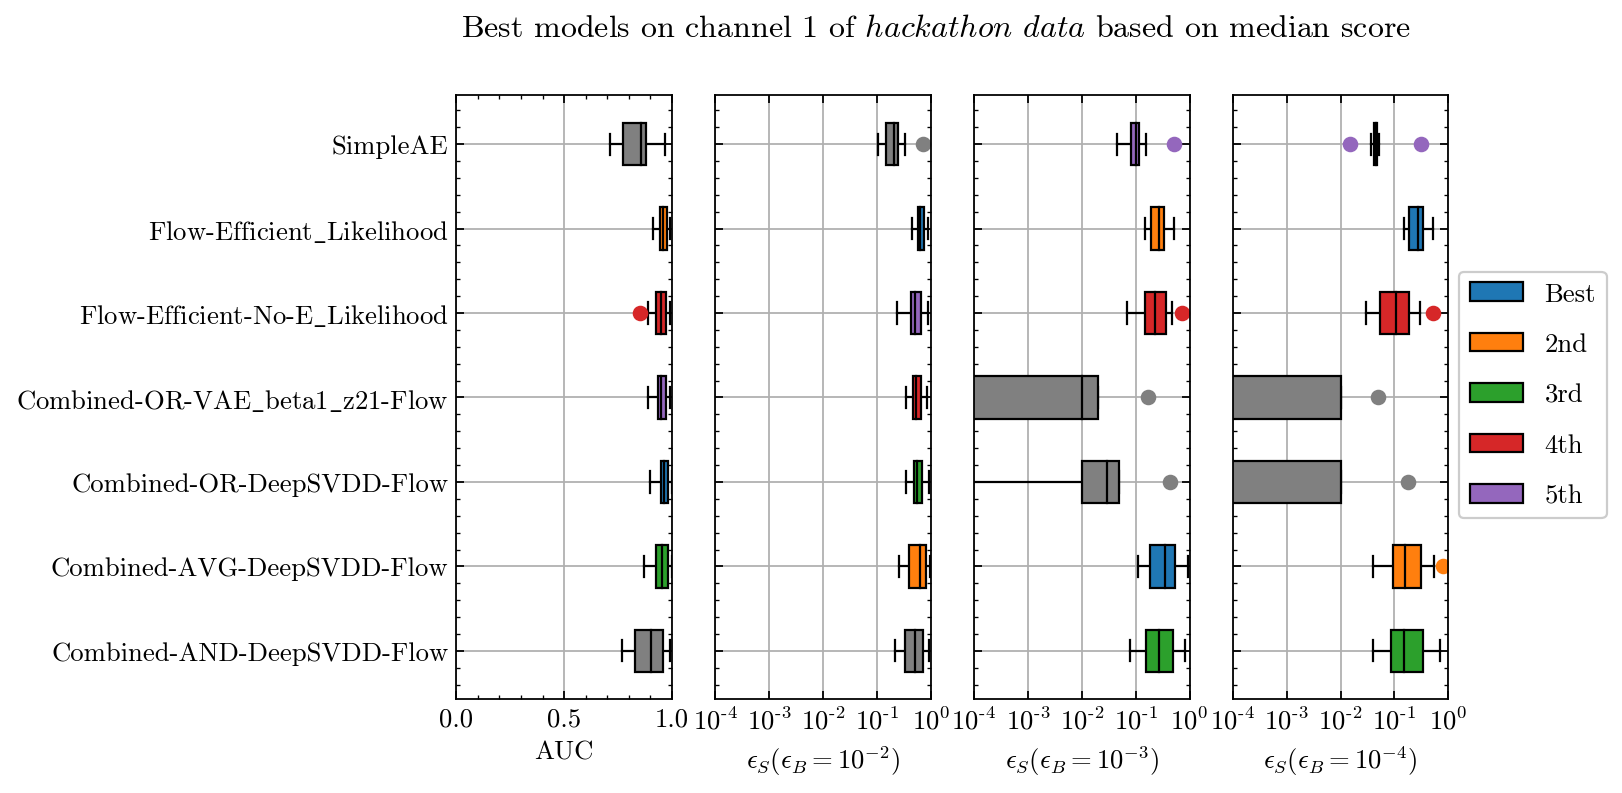

In [30]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='MedianScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Top minimum score

****************************************
Models from chan=1 ranked by metric=AUC sorted by MinScore
                              Model  MinScore
190       Flow-Efficient_Likelihood      0.91
265       Combined-OR-DeepSVDD-Flow      0.90
269  Combined-OR-VAE_beta1_z21-Flow      0.89
267      Combined-AVG-DeepSVDD-Flow      0.87
191  Flow-Efficient-No-E_Likelihood      0.85
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by MinScore
                              Model  MinScore
190       Flow-Efficient_Likelihood      0.44
269  Combined-OR-VAE_beta1_z21-Flow      0.35
265       Combined-OR-DeepSVDD-Flow      0.35
267      Combined-AVG-DeepSVDD-Flow      0.26
191  Flow-Efficient-No-E_Likelihood      0.24
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by MinScore
                              Model  MinScore
190       Flow-E

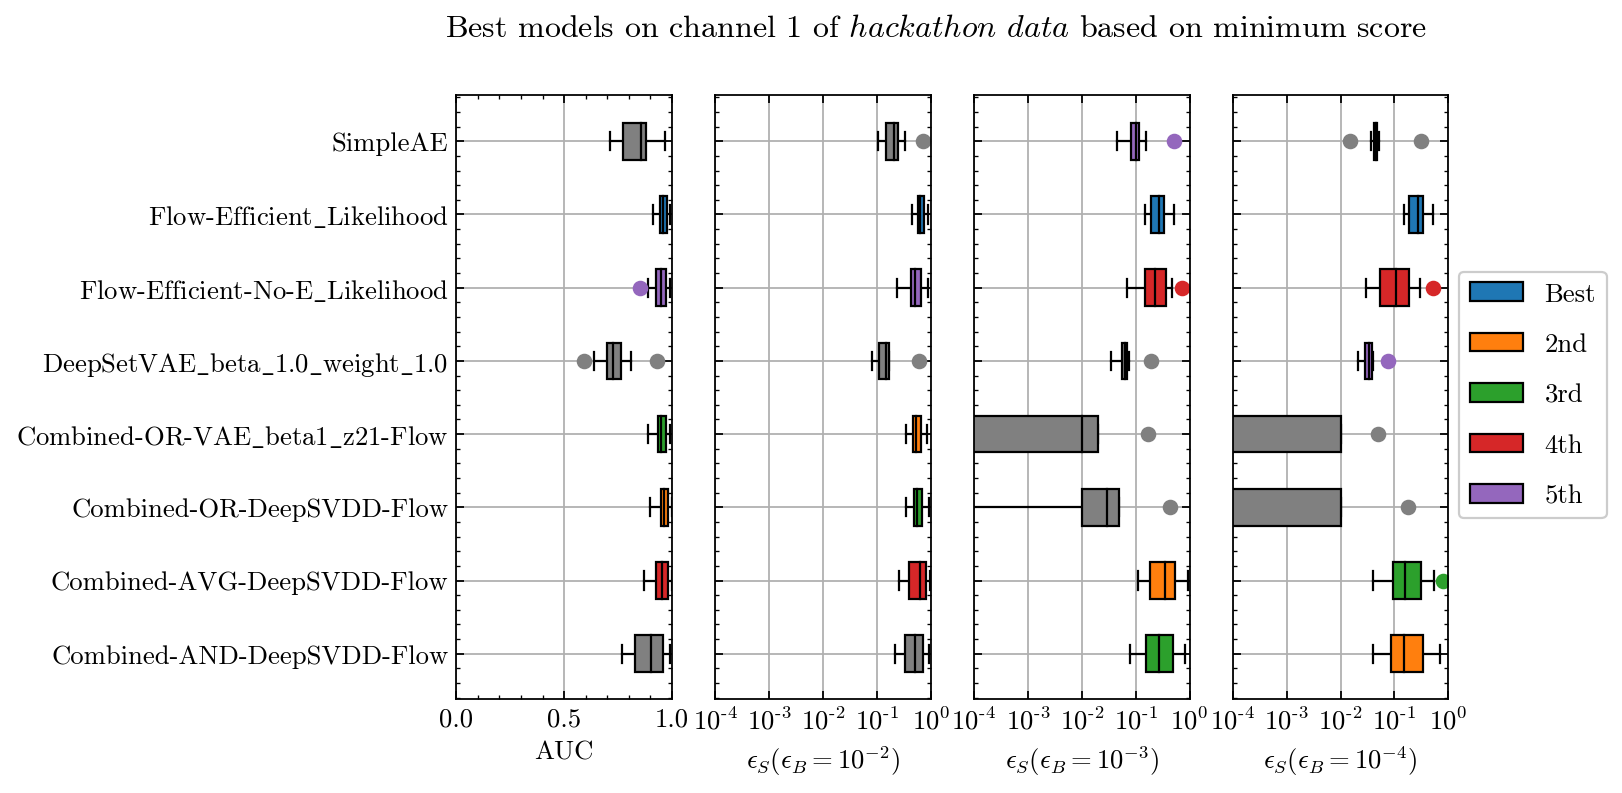

In [31]:
AnalyzeByMethod(AllCombined, 
                Chan='1', 
                Method='MinScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Chan 2a
#### Minimum score on a figure of merit

****************************************
Models from chan=2a ranked by metric=AUC sorted by MinScore
                              Model  MinScore
191  Flow-Efficient-No-E_Likelihood  0.670000
148               VAE_OrthogonalSNF  0.666274
150                         VAE_IAF  0.655265
149               VAE_TriangularSNF  0.655265
147              VAE_HouseholderSNF  0.634438
****************************************

****************************************
Models from chan=2a ranked by metric=1e-2 sorted by MinScore
                              Model  MinScore
190       Flow-Efficient_Likelihood  0.030000
191  Flow-Efficient-No-E_Likelihood  0.020000
152                         CNN_VAE  0.015097
148               VAE_OrthogonalSNF  0.013410
0                          SimpleAE  0.013274
****************************************

****************************************
Models from chan=2a ranked by metric=1e-3 sorted by MinScore
                                            Model  MinScore

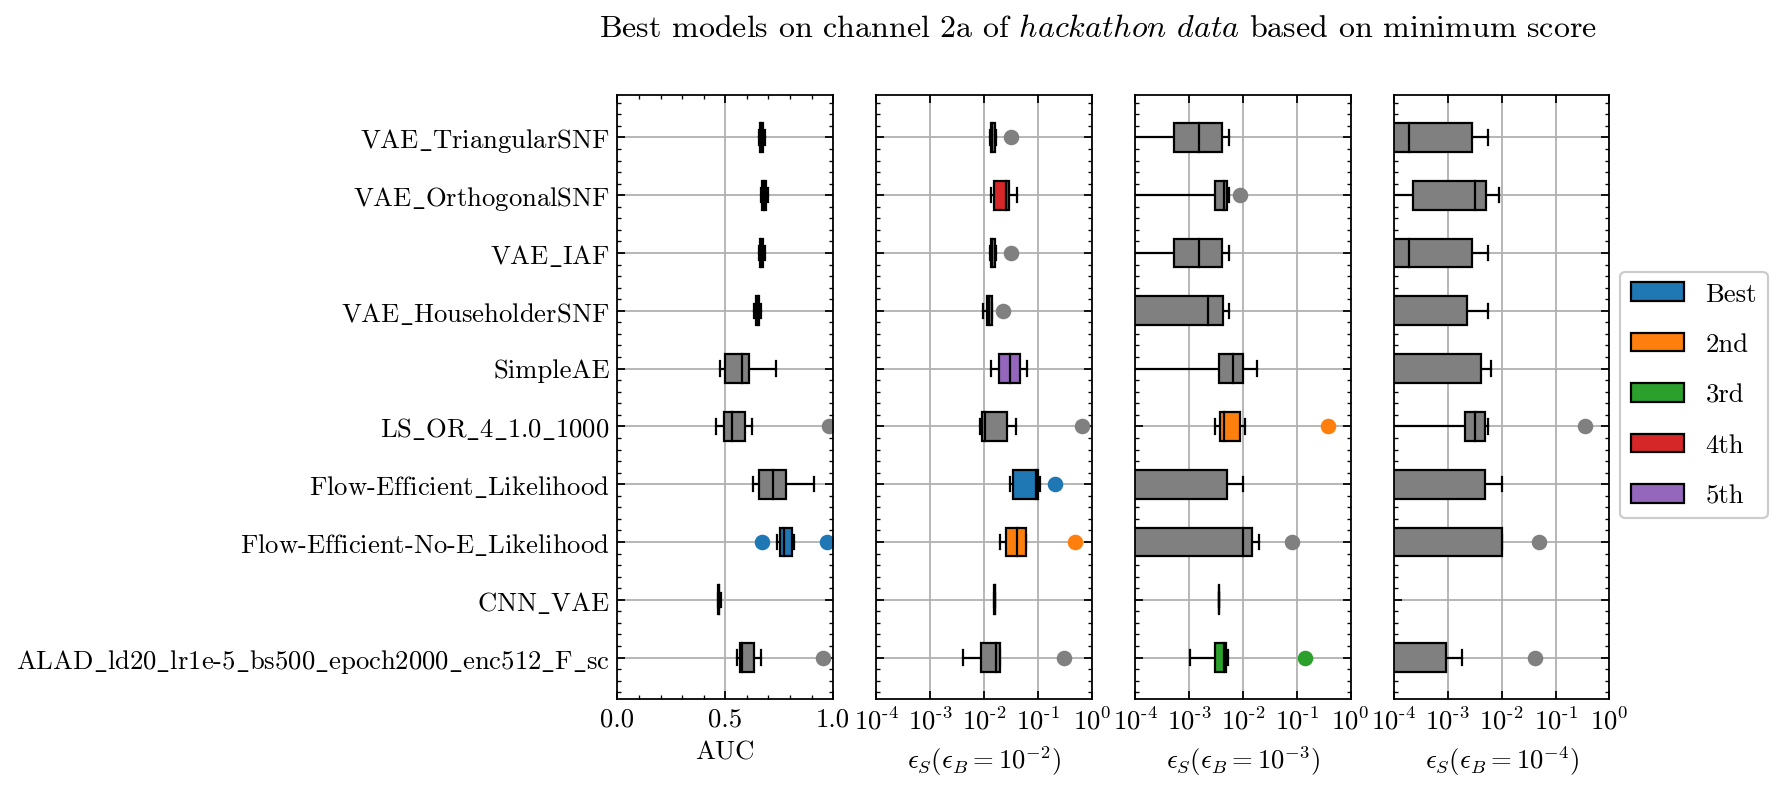

In [32]:
AnalyzeByMethod(AllCombined, 
                Chan='2a', 
                Method='MinScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 3,
                                  '1e-4': 0}, 
                Plot=True
               )

### Chan 2b
#### Minimum score on a figure of merit

****************************************
Models from chan=2b ranked by metric=AUC sorted by MinScore
                              Model  MinScore
265       Combined-OR-DeepSVDD-Flow  0.960000
269  Combined-OR-VAE_beta1_z21-Flow  0.950000
190       Flow-Efficient_Likelihood  0.950000
267      Combined-AVG-DeepSVDD-Flow  0.880000
148               VAE_OrthogonalSNF  0.845863
****************************************

****************************************
Models from chan=2b ranked by metric=1e-2 sorted by MinScore
                              Model  MinScore
266     Combined-PROD-DeepSVDD-Flow      1.00
190       Flow-Efficient_Likelihood      0.62
265       Combined-OR-DeepSVDD-Flow      0.58
269  Combined-OR-VAE_beta1_z21-Flow      0.57
267      Combined-AVG-DeepSVDD-Flow      0.36
****************************************

****************************************
Models from chan=2b ranked by metric=1e-3 sorted by MinScore
                                Model  MinScore
267        

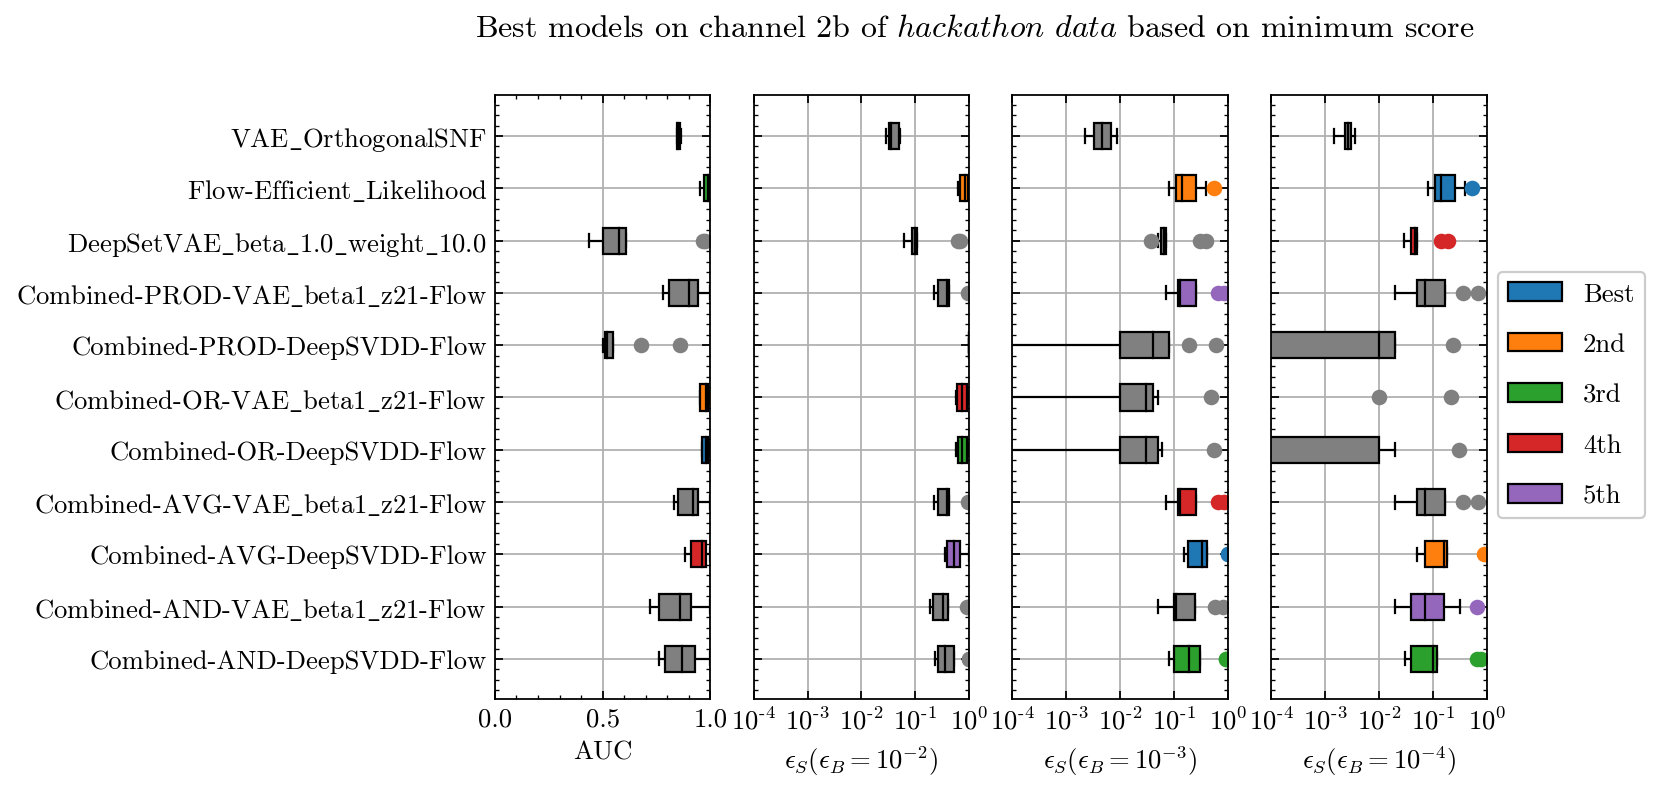

In [33]:
AnalyzeByMethod(AllCombined, 
                Chan='2b', 
                Method='MinScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )

### Chan 3
#### Minimum score on a figure of merit

****************************************
Models from chan=3 ranked by metric=AUC sorted by MinScore
                              Model  MinScore
147              VAE_HouseholderSNF  0.974891
146                  VAE_PlanarFlow  0.966551
190       Flow-Efficient_Likelihood  0.960000
149               VAE_TriangularSNF  0.956197
191  Flow-Efficient-No-E_Likelihood  0.950000
****************************************

****************************************
Models from chan=3 ranked by metric=1e-2 sorted by MinScore
                              Model  MinScore
191  Flow-Efficient-No-E_Likelihood      0.53
190       Flow-Efficient_Likelihood      0.52
269  Combined-OR-VAE_beta1_z21-Flow      0.37
265       Combined-OR-DeepSVDD-Flow      0.36
267      Combined-AVG-DeepSVDD-Flow      0.32
****************************************

****************************************
Models from chan=3 ranked by metric=1e-3 sorted by MinScore
                                Model  MinScore
191    Flow-Ef

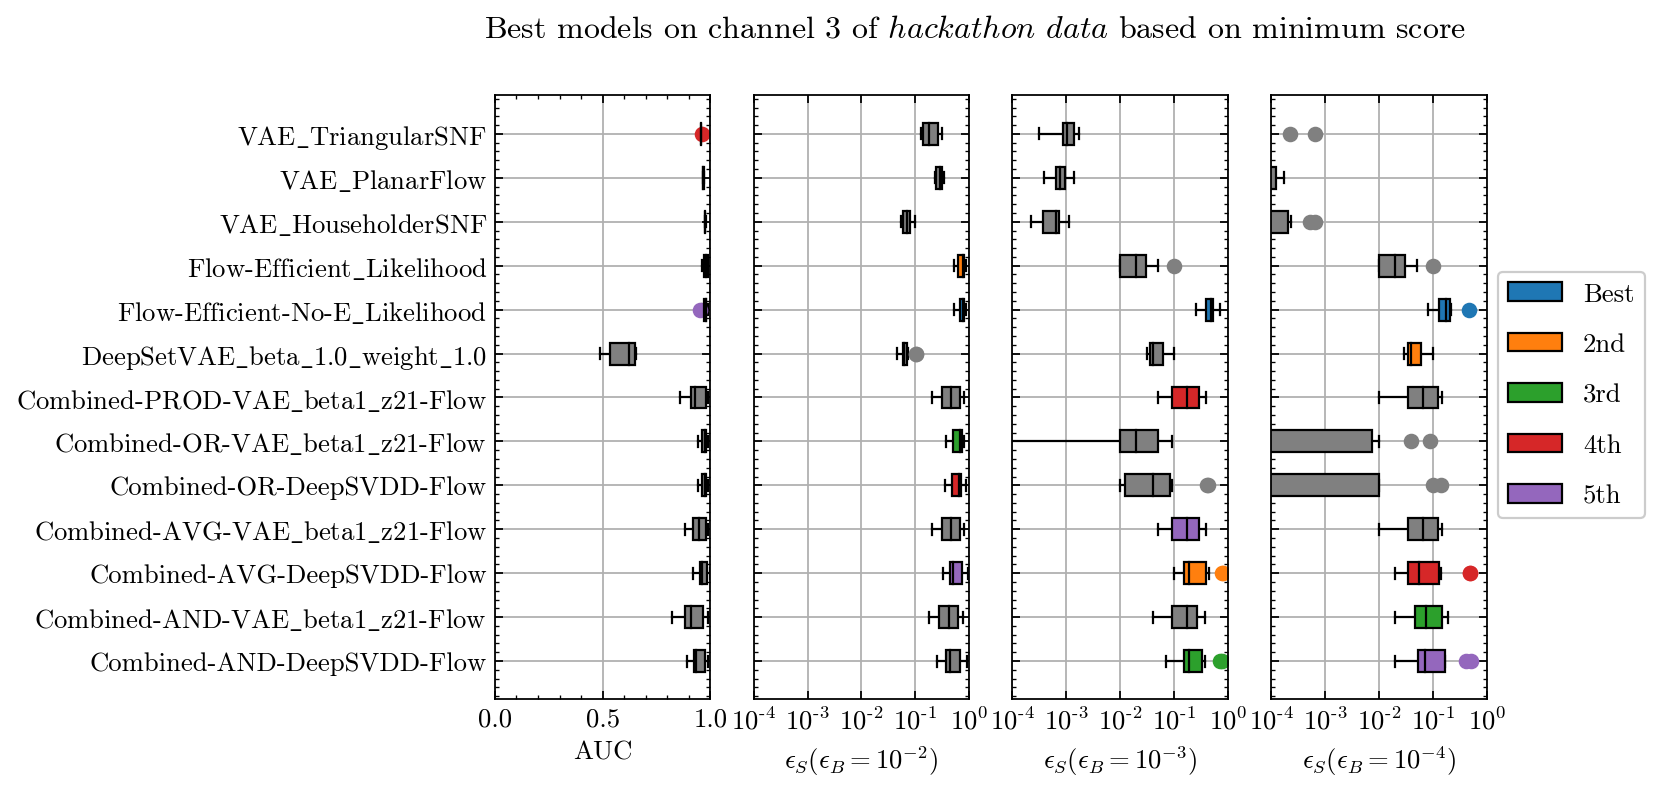

In [34]:
AnalyzeByMethod(AllCombined, 
                Chan='3', 
                Method='MinScore', 
                MetricNumberDict={'AUC': 5,
                                  '1e-2': 5,
                                  '1e-3': 5,
                                  '1e-4': 5}, 
                Plot=True
               )